# To do:
* Check for data-leakage or any other reason the results seem to be be so high
* To consider adding:
 * **More Pre-trained Models** (ex. ResNet50, InceptionV3, EfficientNet)
 * **Optimize Hyperparameter Tuning** (learning rates, batch sizes, and optimizer settings)
 * **Data Augmentation** (more sophisticated augmentation techniques to improve generalization)
 * **K-fold Cross-Validation** (more robust validation, but resource heavy)
 * **Ensemble Methods** (combine models)
 * **Grad-CAM** (CNN analysis)

# Loading libraries & Data

In [12]:
# Standard libraries
import os
import random
import hashlib
import datetime
import re
from dataclasses import dataclass
from itertools import cycle
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

# Data processing & analysis
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import cv2

# Deep Learning - TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
    BatchNormalization, GlobalAveragePooling2D, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint,
    ReduceLROnPlateau, TensorBoard
)

# Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

# For saving to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading Dataset from Kaggle

In [ ]:
# Install Kaggle API
!pip install kaggle

# Import libraries for file upload
from google.colab import files

# Upload kaggle.json file
files.upload()

# Create the Kaggle directory and copy the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

# Unzip dataset quietly (suppress output)
!unzip -q lung-and-colon-cancer-histopathological-images.zip -d data

# **EDA & Pre-Processing**

EDA

Classes: ['lung_n', 'lung_scc', 'lung_aca', 'colon_n', 'colon_aca']
Number of images per class: {'lung_n': 4744, 'lung_scc': 4724, 'lung_aca': 4727, 'colon_n': 4772, 'colon_aca': 4753}


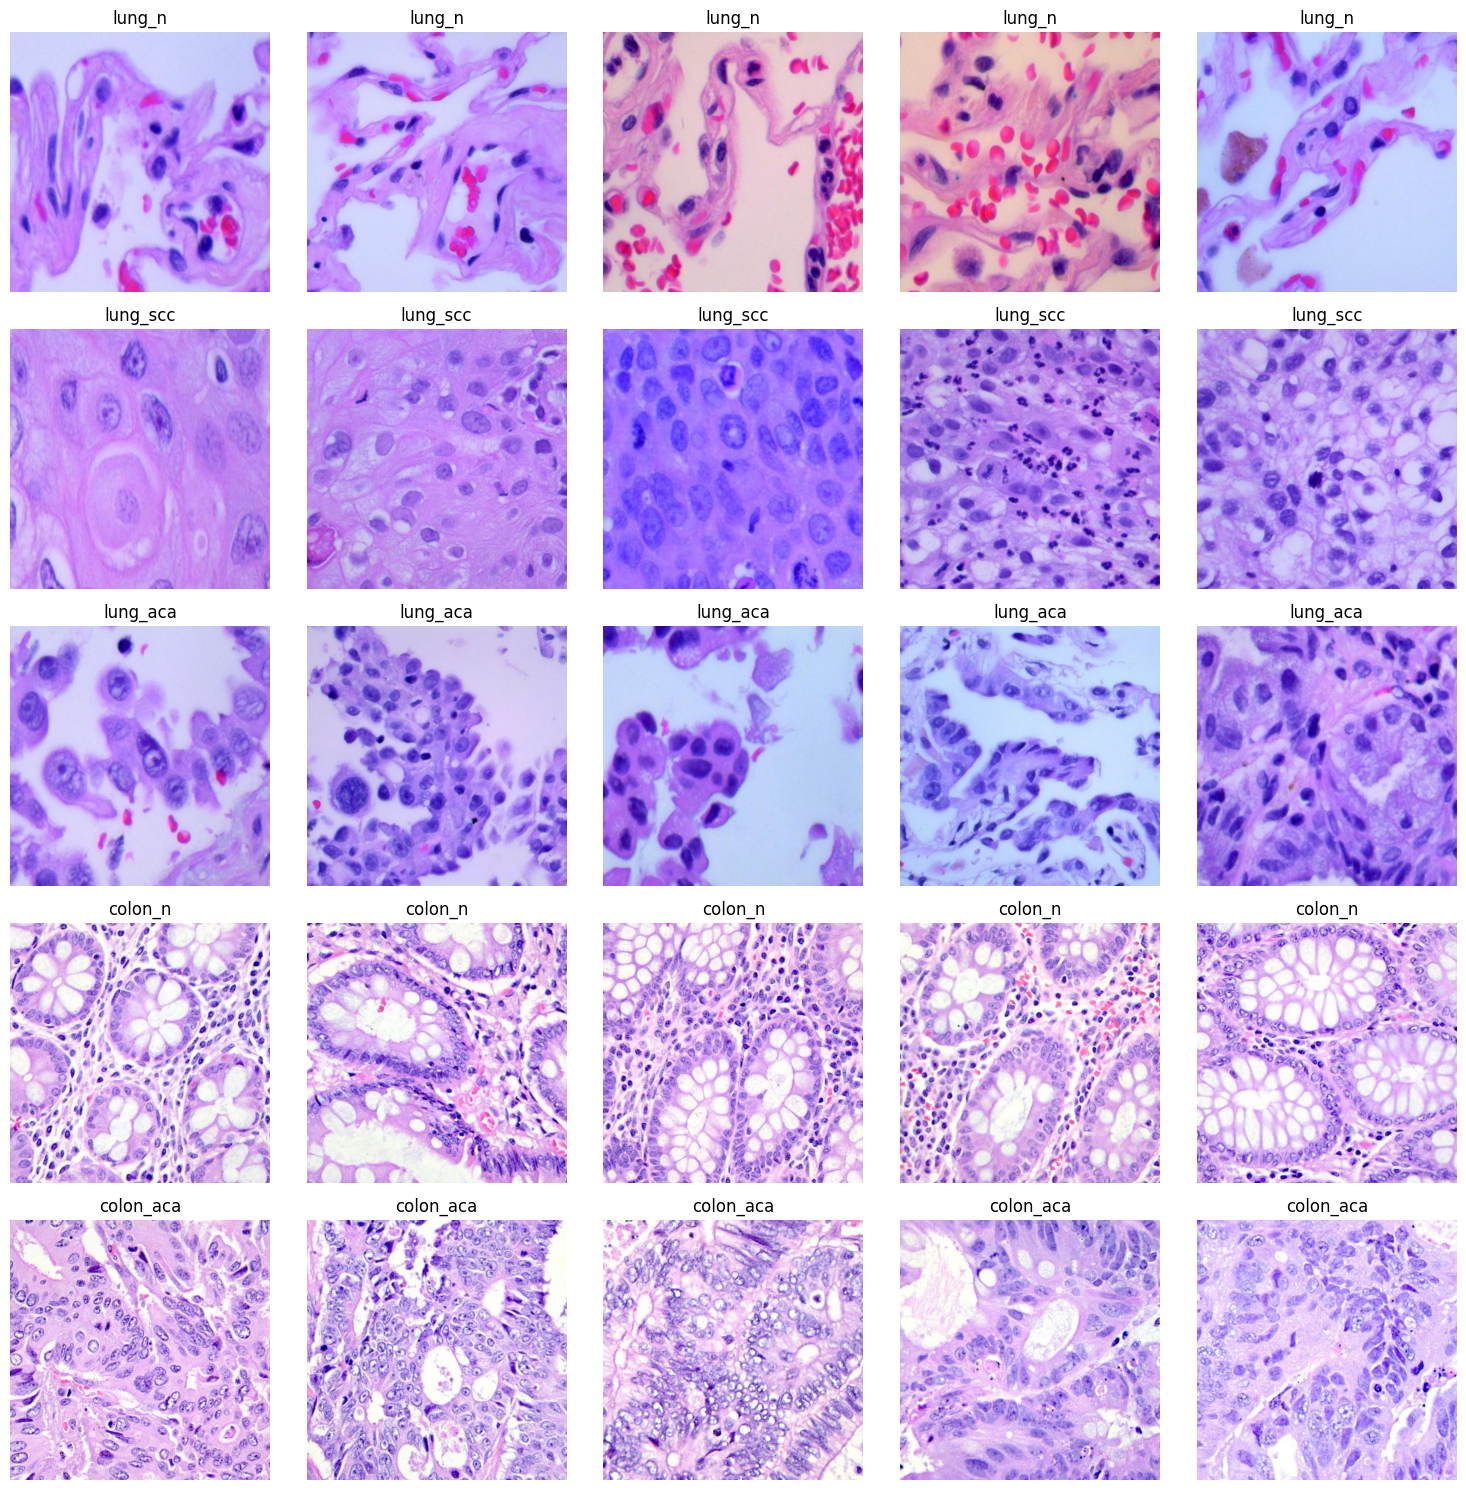


Total duplicate images found: 0
No duplicate images found.

Updated number of images per class after removing duplicates: {'lung_n': 4744, 'lung_scc': 4724, 'lung_aca': 4727, 'colon_n': 4772, 'colon_aca': 4753}


In [26]:
data_dir = Path('data/lung_colon_image_set')
subdirs = ['lung_image_sets', 'colon_image_sets']

def get_classes(data_dir, subdirs):
    """Retrieve class paths from specified subdirectories."""
    class_paths = {}
    for subdir in subdirs:
        subdir_path = data_dir / subdir
        for cls in subdir_path.iterdir():
            if cls.is_dir():
                class_paths.setdefault(cls.name, []).append(cls)
    return class_paths

def display_sample_images(class_paths, images_per_class=5):
    """Display a sample of images from each class."""
    num_classes = len(class_paths)

    # Adjust figure size based on number of classes
    fig_height = num_classes * 3 if num_classes > 0 else 5
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(15, fig_height))

    # Ensure axes is a 2D array
    if num_classes == 1:
        axes = [axes]

    for idx, (cls, paths) in enumerate(class_paths.items()):
        images = []
        for path in paths:
            images.extend(list(path.iterdir()))
        selected_images = random.sample(images, images_per_class)
        for i, img_path in enumerate(selected_images):
            with Image.open(img_path) as img:
                axes[idx, i].imshow(img)
            axes[idx, i].set_title(cls)
            axes[idx, i].axis('off')

    plt.tight_layout()
    plt.show()

def find_and_remove_duplicates(class_paths):
    """Find and remove duplicate images based on MD5 hash."""
    hash_dict = {}
    duplicates = []

    for cls, paths in class_paths.items():
        for path in paths:
            for img_path in path.iterdir():
                if img_path.is_file():
                    with open(img_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                    if file_hash in hash_dict:
                        duplicates.append(img_path)
                    else:
                        hash_dict[file_hash] = img_path

    total_duplicates = len(duplicates)
    print(f"\nTotal duplicate images found: {total_duplicates}")

    # Remove duplicates (without printing each removal)
    if total_duplicates > 0:
        for dup in duplicates:
            dup.unlink()
        print(f"Removed {total_duplicates} duplicate image(s).")
    else:
        print("No duplicate images found.")

def main():
    # Retrieve class paths
    class_paths = get_classes(data_dir, subdirs)

    # Calculate class counts
    class_counts = {cls: sum(len(list(path.iterdir())) for path in paths) for cls, paths in class_paths.items()}

    print("Classes:", list(class_counts.keys()))
    print("Number of images per class:", class_counts)

    # Display sample images
    display_sample_images(class_paths, images_per_class=5)

    # Find and remove duplicate images
    find_and_remove_duplicates(class_paths)

    # Recalculate class counts after removing duplicates
    class_counts = {cls: sum(len(list(path.iterdir())) for path in paths) for cls, paths in class_paths.items()}
    print("\nUpdated number of images per class after removing duplicates:", class_counts)

if __name__ == "__main__":
    main()


Data Preparation

In [21]:
# Creating a DataFrame of Image Paths and Labels
image_paths = []
labels = []

for subdir in ['lung_image_sets', 'colon_image_sets']:
    subdir_path = os.path.join(data_dir, subdir)
    for cls in os.listdir(subdir_path):
        cls_dir = os.path.join(subdir_path, cls)
        if not os.path.isdir(cls_dir):
            continue  # Skip if not a directory
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(cls)
            else:
                print(f"Missing or invalid file skipped: {img_path}")

# Create DataFrame
df = pd.DataFrame({'filename': image_paths, 'label': labels})
df.head()

print("Total samples:", len(df))
print("Missing filenames:", df['filename'].isnull().sum())
print("Missing labels:", df['label'].isnull().sum())

Total samples: 23720
Missing filenames: 0
Missing labels: 0


In [22]:
# Encoding Labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print("Encoded labels:", list(label_encoder.classes_))


Encoded labels: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


Data Splitting

In [25]:
# Split the dataset into training (60%), validation (20%), and test (20%) sets

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_val_idx, test_idx in split.split(df, df['label_encoded']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=1234)
for train_idx, val_idx in split_val.split(train_val_df, train_val_df['label_encoded']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]


print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

print("Training set class distribution:")
print(train_df['label'].value_counts(normalize=True))
print("Validation set class distribution:")
print(val_df['label'].value_counts(normalize=True))
print("Test set class distribution:")
print(test_df['label'].value_counts(normalize=True))

Training set size: 14232
Validation set size: 4744
Test set size: 4744
Training set class distribution:
label
colon_n      0.201237
colon_aca    0.200393
lung_n       0.199972
lung_aca     0.199269
lung_scc     0.199129
Name: proportion, dtype: float64
Validation set class distribution:
label
colon_n      0.201096
colon_aca    0.200253
lung_n       0.200042
lung_aca     0.199410
lung_scc     0.199199
Name: proportion, dtype: float64
Test set class distribution:
label
colon_n      0.201096
colon_aca    0.200464
lung_n       0.200042
lung_aca     0.199199
lung_scc     0.199199
Name: proportion, dtype: float64


# Modeling Methods

In [39]:
# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '1234'
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

# Define image sizes and batch size
IMG_SIZES = {
    'cnn': (224, 224),        # For the CNN model (I'd like to see if increases improves training)
    'vgg16': (224, 224)       # For the VGG16 model
}
BATCH_SIZE = 32
NUM_CLASSES = 5


all_labels = pd.concat([train_df['label'], val_df['label'], test_df['label']])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
CLASSES = list(label_encoder.classes_)

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights_dict = dict(enumerate(class_weights))

# Function to create data generators
def create_generators(train_df, val_df, test_df, img_size, batch_size, model_type='cnn', seed=1234):
    if model_type == 'vgg16':
        preprocessing_function = preprocess_input
    else:
        preprocessing_function = None

    train_datagen = ImageDataGenerator(
        rescale=1./255 if preprocessing_function is None else None,
        preprocessing_function=preprocessing_function,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2],
        channel_shift_range=5
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255 if preprocessing_function is None else None,
        preprocessing_function=preprocessing_function
    )

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        classes=CLASSES,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )

    val_gen = test_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        classes=CLASSES,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
        seed=seed
    )

    test_gen = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        classes=CLASSES,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
        seed=seed
    )

    return train_gen, val_gen, test_gen

# Create generators for CNN
train_gen_cnn, val_gen_cnn, test_gen_cnn = create_generators(
    train_df, val_df, test_df, IMG_SIZES['cnn'], BATCH_SIZE, model_type='cnn'
)

# Create generators for VGG16
train_gen_vgg16, val_gen_vgg16, test_gen_vgg16 = create_generators(
    train_df, val_df, test_df, IMG_SIZES['vgg16'], BATCH_SIZE, model_type='vgg16'
)

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Model-specific checkpoint filepaths
checkpoint_filepath_cnn = f'cnn_model_{timestamp}.keras'
checkpoint_filepath_vgg16 = f'vgg16_model_{timestamp}.keras'

model_checkpoint_cnn = ModelCheckpoint(
    filepath=checkpoint_filepath_cnn,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

model_checkpoint_vgg16 = ModelCheckpoint(
    filepath=checkpoint_filepath_vgg16,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# TensorBoard callback for logging
tensorboard_callback = TensorBoard(log_dir='./logs')

# Variables
epochs = 10  # Adjust based on resource availability

# Build CNN Model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile CNN model
model_cnn = build_cnn_model(IMG_SIZES['cnn'] + (3,), NUM_CLASSES)
model_cnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)


# Build VGG16 Transfer Learning Model
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build & compile VGG16 model
model_vgg16 = build_vgg16_model(IMG_SIZES['vgg16'] + (3,), NUM_CLASSES)
model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

model_cnn.summary()
model_vgg16.summary()

Found 14232 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 14232 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,014,245 (99.24 MB)

 Trainable params: 26,012,581 (99.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,325 (56.64 MB)

 Trainable params: 133,125 (520.02 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

CNN Attempt 8

In [ ]:
# Build and compile CNN model
model_cnn = build_cnn_model(IMG_SIZES['cnn'] + (3,), NUM_CLASSES)
model_cnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Train CNN model
history_cnn = model_cnn.fit(
    train_gen_cnn,
    epochs=epochs,
    validation_data=val_gen_cnn,
    callbacks=[early_stopping, model_checkpoint_cnn, reduce_lr, tensorboard_callback],
    class_weight=class_weights_dict,
    verbose=1
)

# Load best CNN model
best_model_cnn = load_model(checkpoint_filepath_cnn)

# Evaluate CNN model on test data
test_metrics_cnn = best_model_cnn.evaluate(test_gen_cnn, verbose=1)
metric_names = best_model_cnn.metrics_names
for name, value in zip(metric_names, test_metrics_cnn):
    print(f"{name}: {value}")

# Save final model
best_model_cnn.save(f'final_cnn_model_{timestamp}.keras')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.6228 - auc: 0.8838 - loss: 1.0351 - precision: 0.6475 - recall: 0.5821
Epoch 1: val_loss improved from inf to 1.89632, saving model to cnn_model_20241209-201324.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 386s 754ms/step - accuracy: 0.6230 - auc: 0.8839 - loss: 1.0345 - precision: 0.6477 - recall: 0.5823 - val_accuracy: 0.4762 - val_auc: 0.7857 - val_loss: 1.8963 - val_precision: 0.5103 - val_recall: 0.4665 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.8091 - auc: 0.9665 - loss: 0.5015 - precision: 0.8209 - recall: 0.7939
Epoch 2: val_loss improved from 1.89632 to 1.05307, saving model to cnn_model_20241209-201324.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 298s 645ms/step - accuracy: 0.8091 - auc: 0.9665 - loss: 0.5014 - precision: 0.8210 - recall: 0.7940 - val_accuracy: 0.7348 - val_auc: 0.9203 - val_loss: 1.0531 - val_precision: 0.7354 - val_recall: 0.7329 - learning_rate: 1.0000e-04
Epoch 3/10


In [ ]:
# Save to drive:

# Create directory if it doesn't exist
import os
save_path = '/content/drive/MyDrive/ml_models8' # Change load model accordingly
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save CNN model & history
model_cnn.save(f'{save_path}/cnn_model.keras')
import json
with open(f'{save_path}/cnn_history.json', 'w') as f:
    json.dump(history_cnn.history, f)

VGG16 Atempt 8

In [ ]:
# Train VGG16 model
history_vgg16 = model_vgg16.fit(
    train_gen_vgg16,
    epochs=epochs,
    validation_data=val_gen_vgg16,
    callbacks=[early_stopping, model_checkpoint_vgg16, reduce_lr, tensorboard_callback],
    class_weight=class_weights_dict,
    verbose=1
)

# Load best VGG16 model
best_model_vgg16 = load_model(checkpoint_filepath_vgg16)

# Evaluate VGG16 model on test data
test_metrics_vgg16 = best_model_vgg16.evaluate(test_gen_vgg16)
print(f"VGG16 Test Metrics: {test_metrics_vgg16}")

# Fine-tune VGG16 model
# Unfreeze top layers of base model
base_model_vgg16 = best_model_vgg16.layers[0]  # Get base model
base_model_vgg16.trainable = True

# Freeze layers except last convolutional block
for layer in base_model_vgg16.layers[:-4]:
    layer.trainable = False

# Recompile model with a lower learning rate
best_model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Continue training (fine-tuning)
history_vgg16_ft = best_model_vgg16.fit(
    train_gen_vgg16,
    epochs=epochs,
    validation_data=val_gen_vgg16,
    callbacks=[early_stopping, model_checkpoint_vgg16, reduce_lr, tensorboard_callback],
    class_weight=class_weights_dict,
    verbose=1
)

# Load fine-tuned VGG16 model
fine_tuned_model_vgg16 = load_model(checkpoint_filepath_vgg16)

# Evaluate fine-tuned model on test data
fine_tuned_test_metrics_vgg16 = fine_tuned_model_vgg16.evaluate(test_gen_vgg16)
print(f"Fine-tuned VGG16 Test Metrics: {fine_tuned_test_metrics_vgg16}")

# Save final models
fine_tuned_model_vgg16.save(f'fine_tuned_vgg16_model_{timestamp}.keras')

# Save VGG16 model & histories
model_vgg16.save(f'{save_path}/vgg16_model.keras')
with open(f'{save_path}/vgg16_history.json', 'w') as f:
    json.dump(history_vgg16.history, f)
with open(f'{save_path}/vgg16_finetuning_history.json', 'w') as f:
    json.dump(history_vgg16_ft.history, f)

Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.5924 - auc: 0.8466 - loss: 1.1569 - precision: 0.6351 - recall: 0.5316
Epoch 1: val_loss improved from inf to 0.23843, saving model to vgg16_model_20241209-201324.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 340s 711ms/step - accuracy: 0.5927 - auc: 0.8468 - loss: 1.1559 - precision: 0.6355 - recall: 0.5320 - val_accuracy: 0.9136 - val_auc: 0.9915 - val_loss: 0.2384 - val_precision: 0.9214 - val_recall: 0.9045 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8901 - auc: 0.9874 - loss: 0.2981 - precision: 0.9053 - recall: 0.8744
Epoch 2: val_loss improved from 0.23843 to 0.22128, saving model to vgg16_model_20241209-201324.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 300s 666ms/step - accuracy: 0.8901 - auc: 0.9874 - loss: 0.2981 - precision: 0.9053 - recall: 0.8744 - val_accuracy: 0.9222 - val_auc: 0.9915 - val_loss: 0.2213 - val_precision: 0.9283 - val_recall: 0.9169 - learning_rate: 1.0000e

In [ ]:
# Save final models
fine_tuned_model_vgg16.save(f'fine_tuned_vgg16_model_{timestamp}.keras')

# Save VGG16 model & histories
model_vgg16.save(f'{save_path}/vgg16_model.keras')
with open(f'{save_path}/vgg16_history.json', 'w') as f:
    json.dump(history_vgg16.history, f)
with open(f'{save_path}/vgg16_finetuning_history.json', 'w') as f:
    json.dump(history_vgg16_ft.history, f)

ResNet50

In [27]:
# Build ResNet50 Transfer Learning Model
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the base model initially

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build & compile ResNet50 model
model_resnet50 = build_resnet50_model(IMG_SIZES['cnn'] + (3,), NUM_CLASSES)
model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

model_resnet50.summary()

# Model-specific checkpoint filepath for ResNet50
checkpoint_filepath_resnet50 = f'resnet50_model_{timestamp}.keras'

model_checkpoint_resnet50 = ModelCheckpoint(
    filepath=checkpoint_filepath_resnet50,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Train the ResNet50 model
history_resnet50 = model_resnet50.fit(
    train_gen_cnn,
    validation_data=val_gen_cnn,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint_resnet50, reduce_lr, tensorboard_callback]
)

# Evaluate ResNet50 on the test set
test_metrics_resnet50 = model_resnet50.evaluate(test_gen_cnn)
print("\nResNet50 Test Metrics:")
for name, value in zip(model_resnet50.metrics_names, test_metrics_resnet50):
    print(f"{name}: {value:.4f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,565 (91.99 MB)

 Trainable params: 526,341 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.4828 - auc: 0.7932 - loss: 1.2367 - precision: 0.5928 - recall: 0.2740
Epoch 1: val_loss improved from inf to 1.30917, saving model to resnet50_model_20241210-003935.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 254s 532ms/step - accuracy: 0.4830 - auc: 0.7933 - loss: 1.2363 - precision: 0.5930 - recall: 0.2743 - val_accuracy: 0.3651 - val_auc: 0.7920 - val_loss: 1.3092 - val_precision: 0.3828 - val_recall: 0.2669 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6542 - auc: 0.9121 - loss: 0.8320 - precision: 0.7272 - recall: 0.5210
Epoch 2: val_loss improved from 1.30917 to 1.01572, saving model to resnet50_model_20241210-003935.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 229s 508ms/step - accuracy: 0.6542 - auc: 0.9121 - loss: 0.8320 - precision: 0.7272 - recall: 0.5210 - val_accuracy: 0.5601 - val_auc: 0.8833 - val_loss: 1.0157 - val_precision: 0.5990 - val_recall: 0.4987 - learning_rate: 1.0000e-04
E

In [31]:
# Save final ResNet50 model
model_resnet50.save(f'fine_tuned_resnet50_model_{timestamp}.keras')

# Save ResNet50 model & histories
model_resnet50.save(f'{save_path}/resnet50_model.keras')
with open(f'{save_path}/resnet50_history.json', 'w') as f:
    json.dump(history_resnet50.history, f)

# Load Model

In [ ]:
from tensorflow.keras.models import load_model
import json

save_path = '/content/drive/MyDrive/ml_models8'# Keep in sync with load model

# Load models
loaded_cnn = load_model(f'{save_path}/cnn_model.keras')
loaded_vgg16 = load_model(f'{save_path}/vgg16_model.keras')

# Load training histories
with open(f'{save_path}/cnn_history.json', 'r') as f:
    loaded_cnn_history = json.load(f)
with open(f'{save_path}/vgg16_history.json', 'r') as f:
    loaded_vgg16_history = json.load(f)
with open(f'{save_path}/vgg16_finetuning_history.json', 'r') as f:
    loaded_vgg16_ft_history = json.load(f)
print("All loaded")

In [33]:
loaded_resnet50 = load_model(f'{save_path}/resnet50_model.keras')
with open(f'{save_path}/resnet50_history.json', 'r') as f:
    loaded_resnet50_history = json.load(f)


# Validation & Performance Metrics

In [ ]:
# Evaluate CNN on Test Set
print("\n CNN Test Results:")
loss_cnn_test, accuracy_cnn_test, auc_cnn_test, precision_cnn_test, recall_cnn_test = loaded_cnn.evaluate(test_gen_cnn)
print(f"Test Accuracy: {accuracy_cnn_test*100:.2f}%")
print(f"Test AUC: {auc_cnn_test:.4f}")
print(f"Test Precision: {precision_cnn_test:.4f}")
print(f"Test Recall: {recall_cnn_test:.4f}")


# Evaluate VGG16 Fine-Tuned Model on Test Set
print("\nVGG16 Fine-Tuned Test Results:")
loss_vgg16_test, accuracy_vgg16_test, auc_vgg16_test, precision_vgg16_test, recall_vgg16_test = loaded_vgg16.evaluate(test_gen_vgg16)
print(f"Test Accuracy: {accuracy_vgg16_test*100:.2f}%")
print(f"Test AUC: {auc_vgg16_test:.4f}")
print(f"Test Precision: {precision_vgg16_test:.4f}")
print(f"Test Recall: {recall_vgg16_test:.4f}")


 CNN Test Results:
149/149 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.9562 - auc: 0.9971 - loss: 0.1215 - precision: 0.9566 - recall: 0.9559
Test Accuracy: 95.34%
Test AUC: 0.9971
Test Precision: 0.9542
Test Recall: 0.9530

VGG16 Fine-Tuned Test Results:
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 191ms/step - accuracy: 0.9182 - auc: 0.9913 - loss: 0.2295 - precision: 0.9241 - recall: 0.9071
Test Accuracy: 91.57%
Test AUC: 0.9915
Test Precision: 0.9233
Test Recall: 0.9054


In [34]:
# Evaluate ResNet50 on the Test Set
print("\n ResNet50 Test Results:")
loss_resnet50_test, accuracy_resnet50_test, auc_resnet50_test, precision_resnet50_test, recall_resnet50_test = model_resnet50.evaluate(test_gen_cnn)
print(f"Test Accuracy: {accuracy_resnet50_test*100:.2f}%")
print(f"Test AUC: {auc_resnet50_test:.4f}")
print(f"Test Precision: {precision_resnet50_test:.4f}")
print(f"Test Recall: {recall_resnet50_test:.4f}")


 ResNet50 Test Results:
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.7450 - auc: 0.9509 - loss: 0.6034 - precision: 0.7721 - recall: 0.6937
Test Accuracy: 73.92%
Test AUC: 0.9492
Test Precision: 0.7713
Test Recall: 0.6954


# Modeling Results & Findings:

* confusion matrices
* training history
* ROC curves

In [37]:
@dataclass
class PlotConfig:
    """Configuration for plot styling."""
    figsize: tuple = (10, 8)
    title_fontsize: int = 16
    label_fontsize: int = 12
    tick_fontsize: int = 10

class ModelEvaluator:
    """A class for evaluating and visualizing machine learning model performance."""

    def __init__(self, plot_config: Optional[PlotConfig] = None):
        """
        Initialize ModelEvaluator with plot settings.

        Args:
            plot_config: Optional configuration for plot styling
        """
        self.config = plot_config or PlotConfig()
        self._setup_plot_params()

    def _setup_plot_params(self) -> None:
        """Set up matplotlib parameters."""
        plt.rcParams['figure.figsize'] = self.config.figsize
        plt.rcParams['axes.titlesize'] = self.config.title_fontsize
        plt.rcParams['axes.labelsize'] = self.config.label_fontsize
        plt.rcParams['xtick.labelsize'] = self.config.tick_fontsize
        plt.rcParams['ytick.labelsize'] = self.config.tick_fontsize

    def _get_predictions(self, model: Any, generator: Any) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get model predictions and true labels.

        Args:
            model: Trained model to make predictions
            generator: Data generator for the dataset

        Returns:
            tuple: (raw_predictions, predicted_classes, true_labels)
        """
        y_pred = model.predict(generator, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        return y_pred, y_pred_classes, generator.classes

    def _create_figure(self, figsize: Optional[tuple] = None) -> None:
        """Create a new figure with optional custom size."""
        plt.figure(figsize=figsize or self.config.figsize)

    def plot_confusion_matrix(self, model: Any, generator: Any,
                              title: str, normalize: bool = False) -> None:
        """
        Plot confusion matrix and print classification report along with additional metrics.

        Args:
            model: Trained model to evaluate
            generator: Data generator
            title: Plot title
            normalize: Whether to normalize confusion matrix
        """
        y_pred, y_pred_classes, y_true = self._get_predictions(model, generator)

        cm = confusion_matrix(y_true, y_pred_classes,
                             normalize='true' if normalize else None)

        self._create_figure()
        self._plot_confusion_matrix_heatmap(cm, generator.class_indices.keys(),
                                            title, normalize)
        self._print_classification_report(y_true, y_pred_classes,
                                         generator.class_indices.keys(), title)

        # Calculate and print additional metrics
        self._print_additional_metrics(y_true, y_pred_classes, y_pred, title)

    def _print_additional_metrics(self, y_true: np.ndarray,
                                   y_pred_classes: np.ndarray,
                                   y_pred_prob: np.ndarray,
                                   title: str) -> None:
        """
        Calculate and print additional evaluation metrics: F1 Score, Accuracy, MCC, and Log Loss.

        Args:
            y_true: True class labels
            y_pred_classes: Predicted class labels
            y_pred_prob: Predicted probabilities
            title: Title for the evaluation context
        """
        # F1 Score
        f1 = f1_score(y_true, y_pred_classes, average='macro')
        print(f"F1 Score: {f1:.4f}")

        # Accuracy
        accuracy = accuracy_score(y_true, y_pred_classes)
        print(f"Accuracy: {accuracy:.4f}")

        # Matthews Correlation Coefficient
        mcc = matthews_corrcoef(y_true, y_pred_classes)
        print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

        # Log Loss
        try:
            logloss = log_loss(y_true, y_pred_prob)
            print(f"Log Loss: {logloss:.4f}")
        except Exception as e:
            print(f"Log Loss could not be calculated: {e}")

    def _plot_confusion_matrix_heatmap(self, cm: np.ndarray,
                                      class_labels: List[str],
                                      title: str, normalize: bool) -> None:
        """Plot confusion matrix heatmap."""
        fmt = '.2%' if normalize else 'd'
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                    xticklabels=class_labels,
                    yticklabels=class_labels)

        plt.title(title, fontsize=self.config.title_fontsize, pad=20)
        plt.ylabel('True Label', fontsize=self.config.label_fontsize)
        plt.xlabel('Predicted Label', fontsize=self.config.label_fontsize)
        plt.xticks(rotation=45, ha='right', fontsize=self.config.tick_fontsize)
        plt.yticks(fontsize=self.config.tick_fontsize)
        plt.tight_layout()
        plt.show()

    def _print_classification_report(self, y_true: np.ndarray,
                                     y_pred: np.ndarray,
                                     target_names: List[str],
                                     title: str) -> None:
        """Print classification report."""
        print(f"\nClassification Report for {title}:")
        print(classification_report(y_true, y_pred, target_names=target_names))

    def plot_training_history(self, histories: List[Dict],
                              titles: List[str]) -> None:
        """
        Compare training histories of multiple models.

        Args:
            histories: List of training history dictionaries
            titles: List of model titles corresponding to histories
        """
        metrics = {
            'accuracy': {'title': 'Model Accuracy Comparison',
                         'ylabel': 'Accuracy',
                         'legend_loc': 'lower right'},
            'loss': {'title': 'Model Loss Comparison',
                     'ylabel': 'Loss',
                     'legend_loc': 'upper right'}
        }

        plt.figure(figsize=(15, 5))

        for i, (metric, config) in enumerate(metrics.items(), 1):
            plt.subplot(1, 2, i)
            self._plot_metric_history(histories, titles, metric, config)

        plt.tight_layout()
        plt.show()

    def _plot_metric_history(self, histories: List[Dict],
                             titles: List[str],
                             metric: str,
                             config: Dict) -> None:
        """Plot history for a specific metric."""
        for history, title in zip(histories, titles):
            plt.plot(history.get(f'{metric}'), label=f'{title} Train')
            plt.plot(history.get(f'val_{metric}'), label=f'{title} Val')

        plt.title(config['title'], fontsize=self.config.label_fontsize, pad=20)
        plt.ylabel(config['ylabel'], fontsize=self.config.label_fontsize)
        plt.xlabel('Epoch', fontsize=self.config.label_fontsize)
        plt.legend(loc=config['legend_loc'])
        plt.grid(True)

    def plot_multiclass_roc(self, model: Any, generator: Any,
                            n_classes: int, title: str) -> None:
        """
        Plot ROC curves for multiclass classification.

        Args:
            model: Trained model to make predictions
            generator: Data generator for the dataset
            n_classes: Number of classes
            title: Title for the plot
        """
        y_pred, _, y_true = self._get_predictions(model, generator)
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        curves = self._compute_roc_curves(y_true_bin, y_pred, n_classes)
        self._plot_roc_curves(curves, generator.class_indices.keys(), title)

    def _compute_roc_curves(self, y_true: np.ndarray,
                            y_score: np.ndarray,
                            n_classes: int) -> Dict:
        """Compute ROC curves and AUC scores."""
        curves = {'fpr': {}, 'tpr': {}, 'roc_auc': {}}

        # Calculate ROC curve and ROC area for each class
        for i in range(n_classes):
            curves['fpr'][i], curves['tpr'][i], _ = roc_curve(
                y_true[:, i], y_score[:, i]
            )
            curves['roc_auc'][i] = auc(curves['fpr'][i], curves['tpr'][i])

        # Compute micro-average ROC curve and ROC area
        curves['fpr']["micro"], curves['tpr']["micro"], _ = roc_curve(
            y_true.ravel(), y_score.ravel()
        )
        curves['roc_auc']["micro"] = auc(
            curves['fpr']["micro"], curves['tpr']["micro"]
        )

        return curves

    def _plot_roc_curves(self, curves: Dict, class_labels: List[str],
                         title: str) -> None:
        """Plot ROC curves."""
        self._create_figure((8, 6))

        # Plot micro-average ROC curve
        plt.plot(curves['fpr']["micro"], curves['tpr']["micro"],
                 label=f'Micro-average ROC (AUC = {curves["roc_auc"]["micro"]:.2f})',
                 linestyle=':', linewidth=4)

        # Plot ROC curve for each class
        for i, label in enumerate(class_labels):
            plt.plot(curves['fpr'][i], curves['tpr'][i],
                     label=f'Class {label} (AUC = {curves["roc_auc"][i]:.2f})')

        self._format_roc_plot(title)

    def _format_roc_plot(self, title: str) -> None:
        """Format ROC plot with labels and styling."""
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.02, 1.0])
        plt.ylim([0.0, 1.02])
        plt.xlabel('False Positive Rate', fontsize=self.config.label_fontsize)
        plt.ylabel('True Positive Rate', fontsize=self.config.label_fontsize)
        plt.title(title, fontsize=self.config.title_fontsize, pad=20)
        plt.legend(loc="lower right", fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def plot_precision_recall_curve(self, model: Any, generator: Any,
                                     n_classes: int, title: str) -> None:
        """
        Plot Precision-Recall curve for multiclass classification.

        Args:
            model: Trained model to make predictions
            generator: Data generator for the dataset
            n_classes: Number of classes
            title: Title for the plot
        """
        y_pred, _, y_true = self._get_predictions(model, generator)
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        curves = self._compute_pr_curves(y_true_bin, y_pred, n_classes)
        self._plot_pr_curves(curves, generator.class_indices.keys(), title)

    def _compute_pr_curves(self, y_true: np.ndarray,
                            y_score: np.ndarray,
                            n_classes: int) -> Dict:
        """Compute Precision-Recall curves and average precision scores."""
        curves = {'precision': {}, 'recall': {}, 'avg_precision': {}}

        for i in range(n_classes):
            curves['precision'][i], curves['recall'][i], _ = \
                precision_recall_curve(y_true[:, i], y_score[:, i])
            curves['avg_precision'][i] = average_precision_score(
                y_true[:, i], y_score[:, i]
            )

        # Compute micro-average precision-recall curve
        curves['precision']["micro"], curves['recall']["micro"], _ = \
            precision_recall_curve(y_true.ravel(), y_score.ravel())
        curves['avg_precision']["micro"] = average_precision_score(
            y_true, y_score, average="micro"
        )

        return curves

    def _plot_pr_curves(self, curves: Dict, class_labels: List[str],
                        title: str) -> None:
        """Plot Precision-Recall curves."""
        self._create_figure((8, 6))

        # Plot micro-average PR curve
        plt.step(curves['recall']["micro"], curves['precision']["micro"],
                 where='post',
                 label=f'Micro-average PR (AP = {curves["avg_precision"]["micro"]:.2f})')

        # Plot PR curve for each class
        for i, label in enumerate(class_labels):
            plt.step(curves['recall'][i], curves['precision'][i],
                     where='post',
                     label=f'Class {label} (AP = {curves["avg_precision"][i]:.2f})')

        self._format_pr_plot(title)

    def _format_pr_plot(self, title: str) -> None:
        """Format Precision-Recall plot with labels and styling."""
        plt.xlabel('Recall', fontsize=self.config.label_fontsize)
        plt.ylabel('Precision', fontsize=self.config.label_fontsize)
        plt.title(title, fontsize=self.config.title_fontsize, pad=20)
        plt.legend(loc='upper right', fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

def main():
    """Example usage of the ModelEvaluator class."""
    # Initialize plot configuration with specified figure size and title font size
    config = PlotConfig(figsize=(12, 10), title_fontsize=18)

    # Initialize the ModelEvaluator with the custom plot configuration
    evaluator = ModelEvaluator(plot_config=config)

    # Compare the training histories of different models to assess convergence and overfitting
    histories = [loaded_cnn_history, loaded_vgg16_history, loaded_vgg16_ft_history]
    titles = ['CNN', 'VGG16', 'VGG16 Fine-Tuned']
    evaluator.plot_training_history(histories, titles)


    # Plot the standard confusion matrix for the CNN model
    evaluator.plot_confusion_matrix(loaded_cnn, test_gen_cnn, 'CNN Confusion Matrix')

    # Plot the normalized confusion matrix to understand class-wise performance
    evaluator.plot_confusion_matrix(loaded_cnn, test_gen_cnn,
                                    'Normalized Confusion Matrix - CNN', normalize=True)

    # Determine the number of classes for multiclass ROC and Precision-Recall curves
    n_classes = len(test_gen_cnn.class_indices)

    # Plot ROC curves for each class in the CNN model
    evaluator.plot_multiclass_roc(loaded_cnn, test_gen_cnn, n_classes, 'CNN ROC Curve')

    # Plot Precision-Recall curves for each class in the CNN model
    evaluator.plot_precision_recall_curve(loaded_cnn, test_gen_cnn, n_classes,
                                          'CNN Precision-Recall Curve')

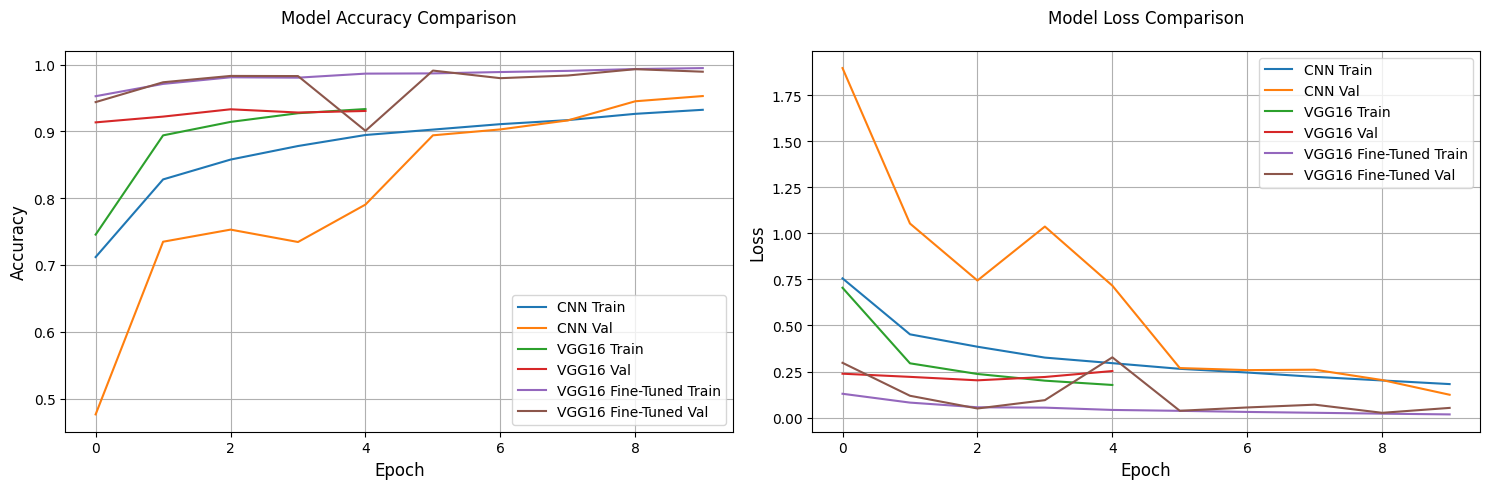

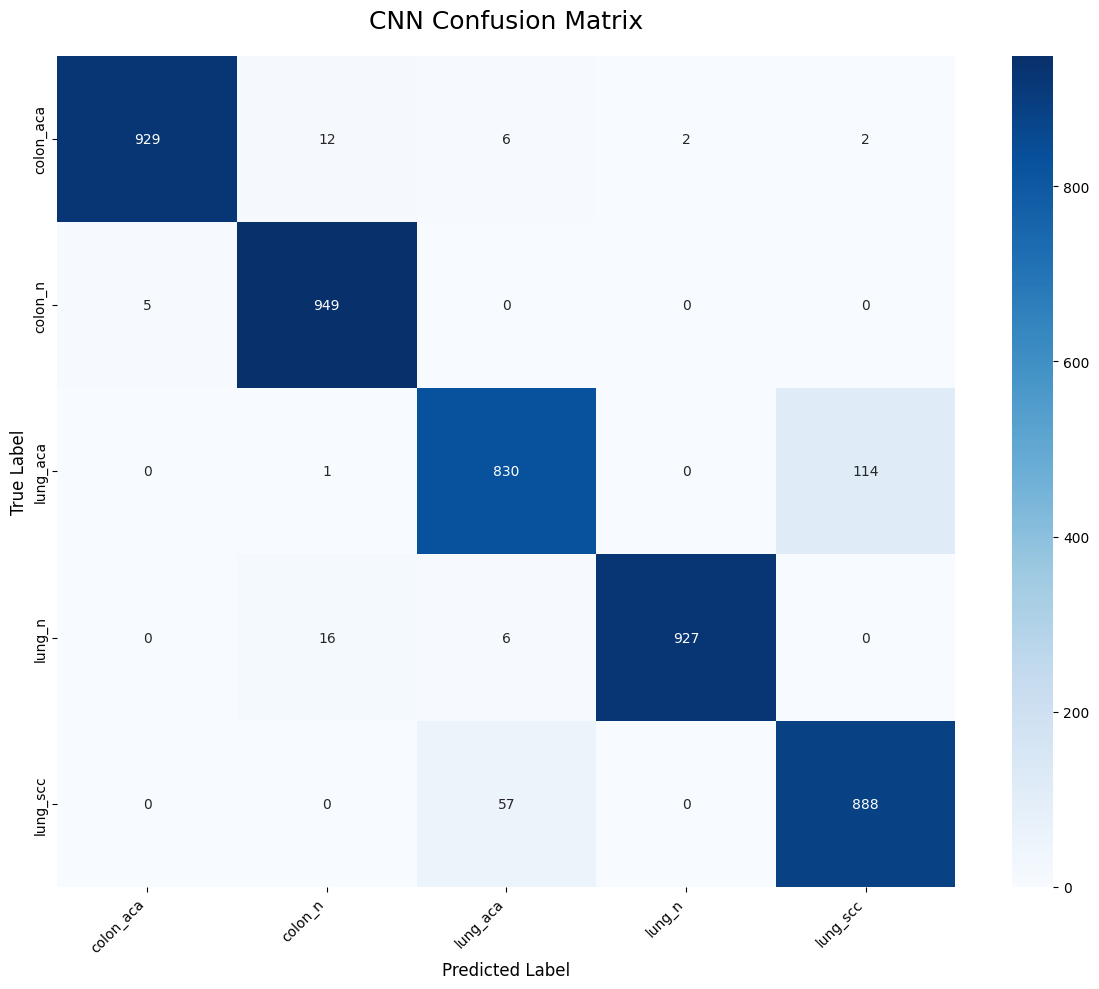


Classification Report for CNN Confusion Matrix:
              precision    recall  f1-score   support

   colon_aca       0.99      0.98      0.99       951
     colon_n       0.97      0.99      0.98       954
    lung_aca       0.92      0.88      0.90       945
      lung_n       1.00      0.98      0.99       949
    lung_scc       0.88      0.94      0.91       945

    accuracy                           0.95      4744
   macro avg       0.95      0.95      0.95      4744
weighted avg       0.95      0.95      0.95      4744

F1 Score: 0.9534
Accuracy: 0.9534
Matthews Correlation Coefficient (MCC): 0.9419
Log Loss: 0.1238


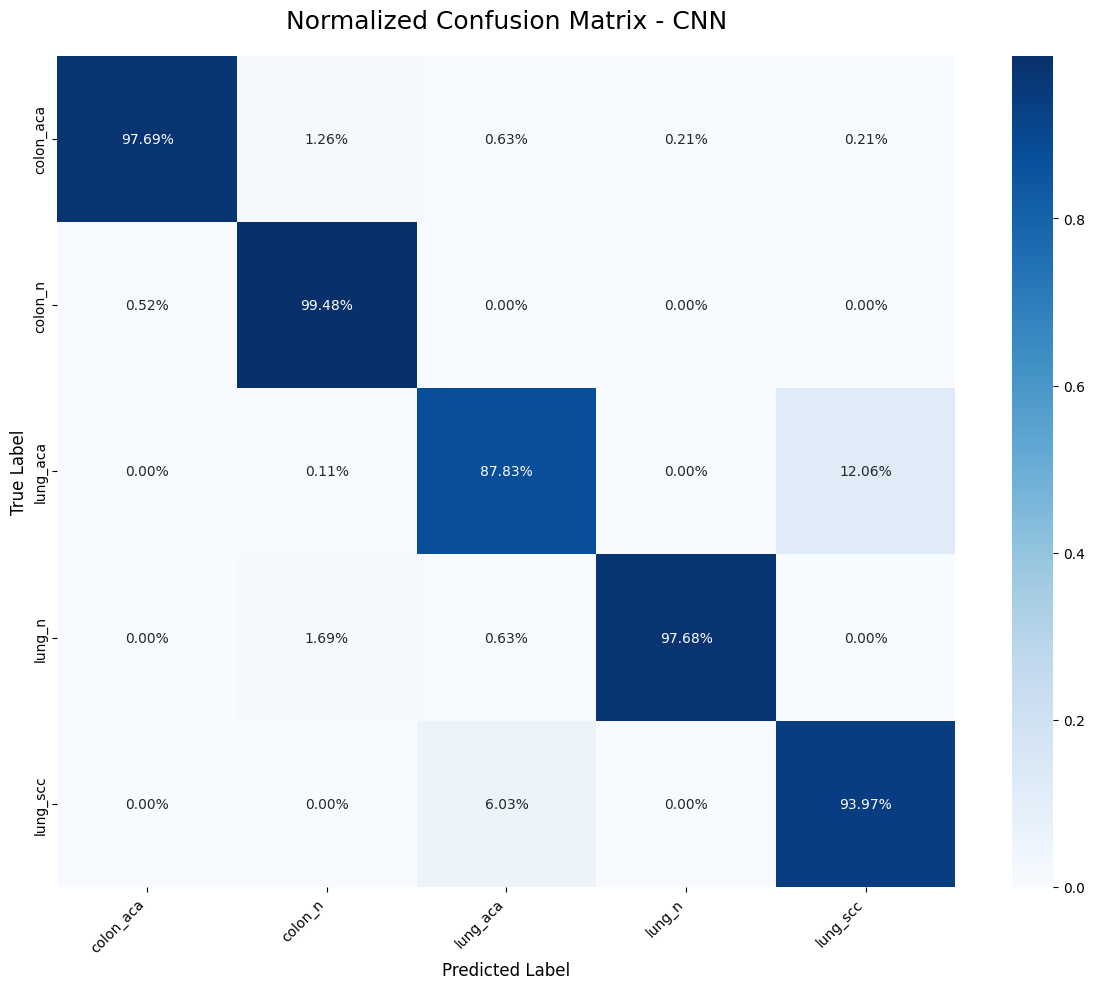


Classification Report for Normalized Confusion Matrix - CNN:
              precision    recall  f1-score   support

   colon_aca       0.99      0.98      0.99       951
     colon_n       0.97      0.99      0.98       954
    lung_aca       0.92      0.88      0.90       945
      lung_n       1.00      0.98      0.99       949
    lung_scc       0.88      0.94      0.91       945

    accuracy                           0.95      4744
   macro avg       0.95      0.95      0.95      4744
weighted avg       0.95      0.95      0.95      4744

F1 Score: 0.9534
Accuracy: 0.9534
Matthews Correlation Coefficient (MCC): 0.9419
Log Loss: 0.1238


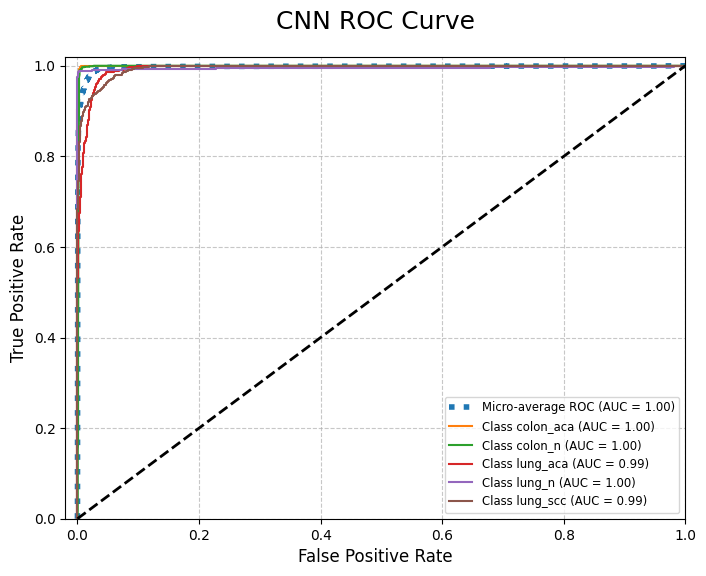

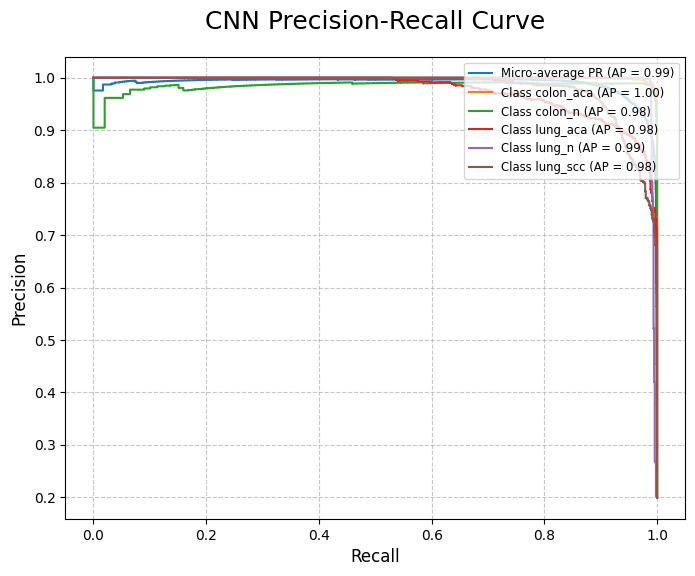

In [ ]:

if __name__ == "__main__":
    main()


Evaluating ResNet50 Model:


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


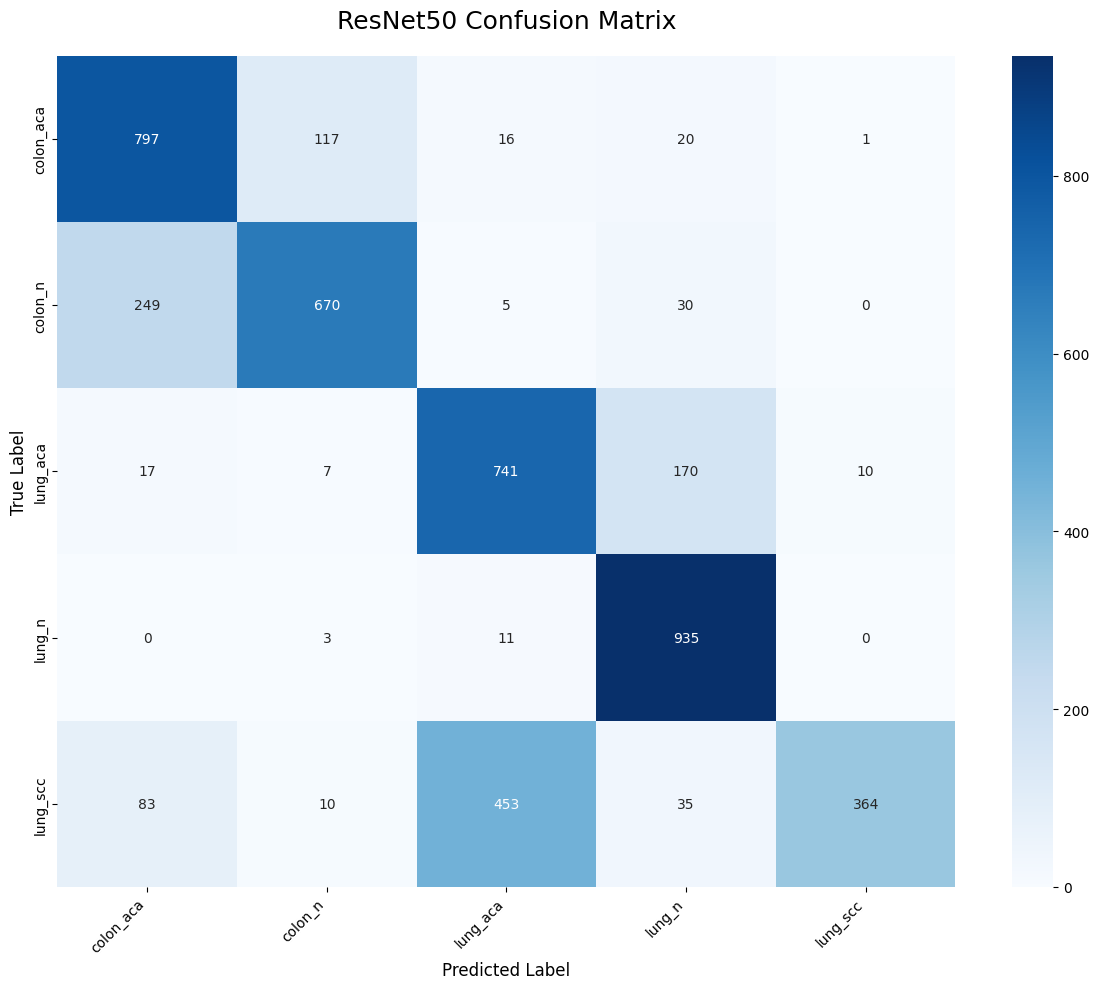


Classification Report for ResNet50 Confusion Matrix:
              precision    recall  f1-score   support

   colon_aca       0.70      0.84      0.76       951
     colon_n       0.83      0.70      0.76       954
    lung_aca       0.60      0.78      0.68       945
      lung_n       0.79      0.99      0.87       949
    lung_scc       0.97      0.39      0.55       945

    accuracy                           0.74      4744
   macro avg       0.78      0.74      0.73      4744
weighted avg       0.78      0.74      0.73      4744

F1 Score: 0.7259
Accuracy: 0.7392
Matthews Correlation Coefficient (MCC): 0.6840
Log Loss: 0.6160


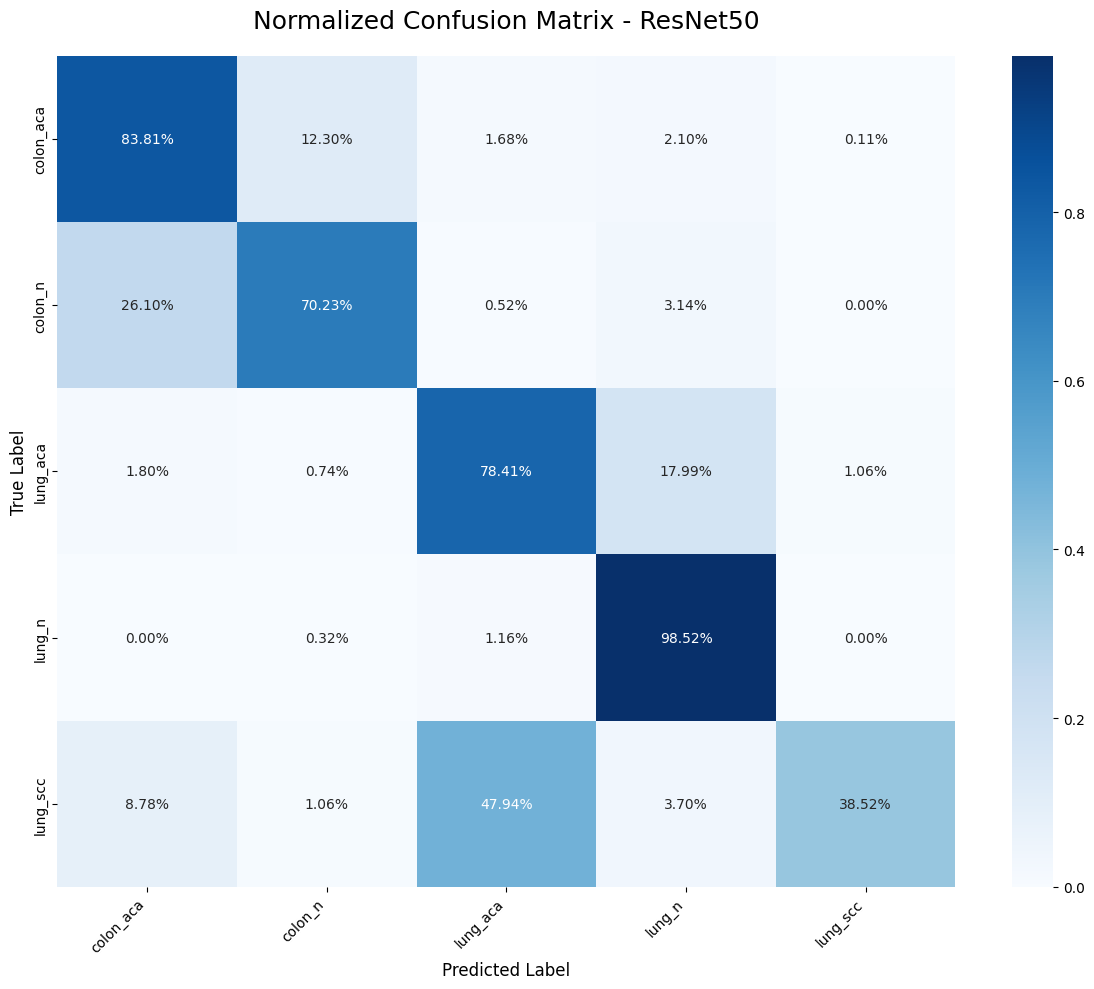


Classification Report for Normalized Confusion Matrix - ResNet50:
              precision    recall  f1-score   support

   colon_aca       0.70      0.84      0.76       951
     colon_n       0.83      0.70      0.76       954
    lung_aca       0.60      0.78      0.68       945
      lung_n       0.79      0.99      0.87       949
    lung_scc       0.97      0.39      0.55       945

    accuracy                           0.74      4744
   macro avg       0.78      0.74      0.73      4744
weighted avg       0.78      0.74      0.73      4744

F1 Score: 0.7259
Accuracy: 0.7392
Matthews Correlation Coefficient (MCC): 0.6840
Log Loss: 0.6160


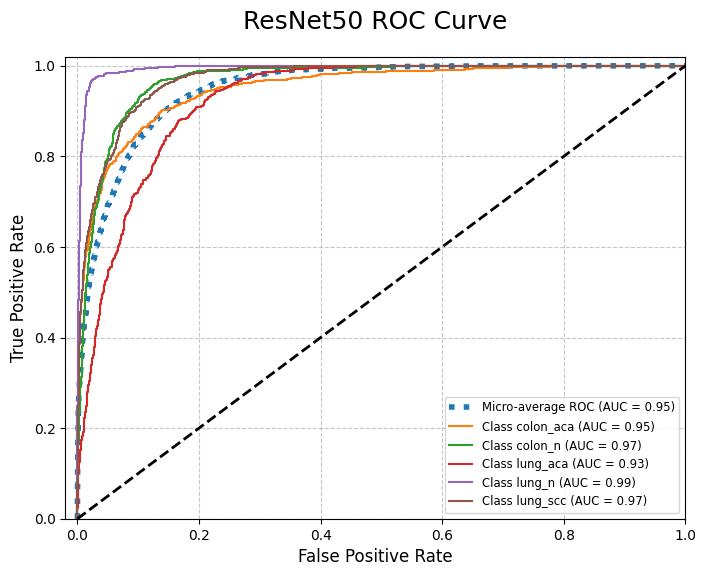

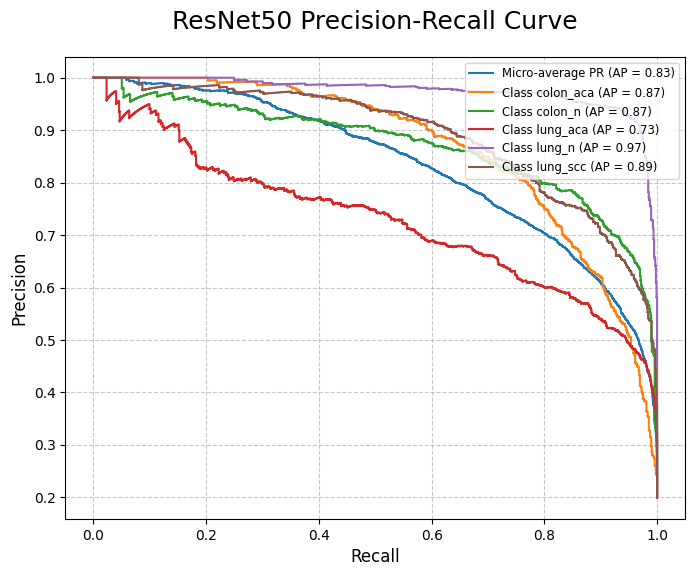

In [41]:
def main():
    """Example usage of the ModelEvaluator class."""
    # Initialize plot configuration with specified figure size and title font size
    config = PlotConfig(figsize=(12, 10), title_fontsize=18)

    # Initialize the ModelEvaluator with the custom plot configuration
    evaluator = ModelEvaluator(plot_config=config)

    # Load ResNet50 model and history
    loaded_resnet50 = load_model(f'{save_path}/resnet50_model.keras')
    with open(f'{save_path}/resnet50_history.json', 'r') as f:
        loaded_resnet50_history = json.load(f)

    # Evaluate and visualize metrics for ResNet50
    print("\nEvaluating ResNet50 Model:")

    # Plot the standard confusion matrix for the ResNet50 model
    evaluator.plot_confusion_matrix(loaded_resnet50, test_gen_cnn, 'ResNet50 Confusion Matrix')

    # Plot the normalized confusion matrix to understand class-wise performance
    evaluator.plot_confusion_matrix(loaded_resnet50, test_gen_cnn,
                                    'Normalized Confusion Matrix - ResNet50', normalize=True)

    # Determine the number of classes for multiclass ROC and Precision-Recall curves
    n_classes = len(test_gen_cnn.class_indices)

    # Plot ROC curves for each class in the ResNet50 model
    evaluator.plot_multiclass_roc(loaded_resnet50, test_gen_cnn, n_classes, 'ResNet50 ROC Curve')

    # Plot Precision-Recall curves for each class in the ResNet50 model
    evaluator.plot_precision_recall_curve(loaded_resnet50, test_gen_cnn, n_classes,
                                          'ResNet50 Precision-Recall Curve')

if __name__ == "__main__":
    main()


# Model validation: Trying to figure out why the model seems to have trained too well too quickly. (needs work)

Potential causes:
* Data Leakage
* Clever Hans Effect
* Testing on Non-Independent Data
* Data Preprocessing Artifacts:
 * Normalization applied inconsistently between training and testing.
 * Using preprocessed features that include target information.

Check for overlap between splits

In [9]:
# Check if filenames are unique in each split
if not train_df['filename'].is_unique:
    print("Duplicate filenames in train")
if not val_df['filename'].is_unique:
    print("duplicate filenames in val")
if not test_df['filename'].is_unique:
    print("duplicate filenames in test")

# Check for overlap between splits
if not set(train_df['filename']).isdisjoint(set(val_df['filename'])):
    print("Train & Val overlap")
if not set(train_df['filename']).isdisjoint(set(test_df['filename'])):
    print("Train & Test overlap")
if not set(val_df['filename']).isdisjoint(set(test_df['filename'])):
    print("Val & Test overlap")

Image Similarity Analysis

In [14]:
def get_image_arrays(paths, batch_size=100):
    """Vectorized conversion of images to arrays with batching."""
    all_arrays = []
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i + batch_size]
        batch_arrays = []
        for path in batch_paths:
            img = Image.open(path)
            img = img.resize((224, 224))
            batch_arrays.append(np.array(img).flatten())
        all_arrays.extend(batch_arrays)
    return np.array(all_arrays)

def compute_pairwise_similarities(arrays1, arrays2=None, batch_size=1000):
    """Compute pairwise similarities with batching for memory efficiency."""
    if arrays2 is None:
        arrays2 = arrays1
    n1, n2 = len(arrays1), len(arrays2)
    similarities = np.zeros((n1, n2))
    for i in range(0, n1, batch_size):
        batch1 = arrays1[i:i + batch_size]
        for j in range(0, n2, batch_size):
            batch2 = arrays2[j:j + batch_size]
            batch_similarities = cosine_similarity(batch1, batch2)
            similarities[i:i + len(batch1), j:j + len(batch2)] = batch_similarities
    return similarities

def extract_number(filename):
    """Extract numerical suffix from filename."""
    match = re.search(r'(\d+)\.jpeg$', filename)
    return int(match.group(1)) if match else None

def analyze_dataset_structure(df):
    """Analyze basic dataset statistics."""
    stats = {
        'total_images (in training set)': len(df),
        'class_distribution': df['label'].value_counts().to_dict(),
        'class_percentages': df['label'].value_counts(normalize=True).to_dict(),
        'duplicate_filenames': df['filename'].duplicated().sum(),
        'unique_directories': len(set(df['filename'].apply(os.path.dirname)))
    }
    return stats

def analyze_visual_similarities(df, sample_size=100):
    """Analyze visual similarities within dataset."""
    results = []

    for class_name in df['label'].unique():
        class_files = df[df['label'] == class_name]
        if len(class_files) > sample_size:
            class_files = class_files.sample(sample_size)

        files = class_files['filename'].tolist()
        numbers = [extract_number(f) for f in files]
        valid_indices = [i for i, n in enumerate(numbers) if n is not None]

        if not valid_indices:
            continue

        files = [files[i] for i in valid_indices]
        numbers = np.array([numbers[i] for i in valid_indices])

        image_arrays = get_image_arrays(files)
        similarities_matrix = compute_pairwise_similarities(image_arrays)

        i_upper, j_upper = np.triu_indices(len(files), k=1)
        similarities = similarities_matrix[i_upper, j_upper]
        number_diffs = np.abs(numbers[i_upper] - numbers[j_upper])

        if len(similarities) > 0:
            correlation, p_value = stats.pearsonr(number_diffs, similarities)

            results.append({
                'class': class_name,
                'correlation': correlation,
                'p_value': p_value,
                'n_comparisons': len(similarities),
                'mean_similarity': np.mean(similarities),
                'std_similarity': np.std(similarities),
                'mean_number_diff': np.mean(number_diffs),
                'std_number_diff': np.std(number_diffs)
            })

    return pd.DataFrame(results)

def analyze_cross_dataset_similarities(source_df, target_df, sample_size=100):
    """Analyze similarities between two datasets."""
    source_sample = source_df.sample(min(len(source_df), sample_size))
    target_sample = target_df.sample(min(len(target_df), sample_size))

    source_arrays = get_image_arrays(source_sample['filename'].tolist())
    target_arrays = get_image_arrays(target_sample['filename'].tolist())
    similarities_matrix = compute_pairwise_similarities(source_arrays, target_arrays)

    similarities = []
    for i, (_, source_row) in enumerate(source_sample.iterrows()):
        for j, (_, target_row) in enumerate(target_sample.iterrows()):
            similarities.append({
                'similarity': similarities_matrix[i, j],
                'same_class': source_row['label'] == target_row['label'],
                'source_class': source_row['label'],
                'target_class': target_row['label']
            })

    similarities_df = pd.DataFrame(similarities)
    same_class = similarities_df[similarities_df['same_class']]['similarity']
    diff_class = similarities_df[~similarities_df['same_class']]['similarity']

    stats_dict = {
        'n_comparisons': len(similarities),
        'mean_similarity': similarities_df['similarity'].mean(),
        'std_similarity': similarities_df['similarity'].std(),
        'median_similarity': similarities_df['similarity'].median(),
        'min_similarity': similarities_df['similarity'].min(),
        'max_similarity': similarities_df['similarity'].max(),
        'same_class_stats': {
            'mean': same_class.mean(),
            'std': same_class.std(),
            'count': len(same_class)
        },
        'diff_class_stats': {
            'mean': diff_class.mean(),
            'std': diff_class.std(),
            'count': len(diff_class)
        }
    }

    if len(same_class) > 0 and len(diff_class) > 0:
        t_stat, p_value = stats.ttest_ind(same_class, diff_class)
        stats_dict.update({
            't_statistic': t_stat,
            'p_value': p_value
        })

    return stats_dict

def print_statistical_report(results):
    """Print statistical analysis results."""
    print("\nDATASET STATISTICAL ANALYSIS")
    print("="*50)

    # Dataset Structure
    structure = results['structure']
    print("\n1. Dataset Composition")
    print(f"Total Images: {structure['total_images']}")
    print("\nClass Distribution:")
    for class_name, count in structure['class_distribution'].items():
        percentage = structure['class_percentages'][class_name] * 100
        print(f"  {class_name}: {count} images ({percentage:.1f}%)")
    print(f"\nUnique Directories: {structure['unique_directories']}")
    print(f"Duplicate Filenames: {structure['duplicate_filenames']}")

    # Visual Similarities
    print("\n2. Visual Similarity Analysis")
    if not results['visual_similarities'].empty:
        print("\nCorrelation Statistics by Class:")
        print(results['visual_similarities'].round(4).to_string(index=False))

    # Cross-Dataset Analysis
    if 'cross_dataset' in results:
        print("\n3. Cross-Dataset Statistics")
        cross_stats = results['cross_dataset']
        print(f"\nComparisons: {cross_stats['n_comparisons']}")
        print(f"\nOverall Similarity Statistics:")
        print(f"  Mean: {cross_stats['mean_similarity']:.4f}")
        print(f"  Std Dev: {cross_stats['std_similarity']:.4f}")
        print(f"  Median: {cross_stats['median_similarity']:.4f}")
        print(f"  Range: [{cross_stats['min_similarity']:.4f}, {cross_stats['max_similarity']:.4f}]")

        if 't_statistic' in cross_stats:
            print(f"\nSame vs Different Class Statistics:")
            print("  Same Class:")
            print(f"    Mean: {cross_stats['same_class_stats']['mean']:.4f}")
            print(f"    Std Dev: {cross_stats['same_class_stats']['std']:.4f}")
            print("  Different Class:")
            print(f"    Mean: {cross_stats['diff_class_stats']['mean']:.4f}")
            print(f"    Std Dev: {cross_stats['diff_class_stats']['std']:.4f}")
            print(f"\nT-test Results:")
            print(f"  T-statistic: {cross_stats['t_statistic']:.4f}")
            print(f"  P-value: {cross_stats['p_value']:.4e}")

def analyze_ml_dataset(df, source_df=None, target_df=None, sample_size=100):
    """Main function to analyze ML dataset statistics."""
    results = {
        'structure': analyze_dataset_structure(df),
        'visual_similarities': analyze_visual_similarities(df, sample_size)
    }

    if source_df is not None and target_df is not None:
        results['cross_dataset'] = analyze_cross_dataset_similarities(
            source_df, target_df, sample_size=sample_size
        )

    return results

if __name__ == "__main__":
    # Example usage
    results = analyze_ml_dataset(
        df=train_df,
        source_df=test_df,
        target_df=train_df,
        sample_size=500
    )
    print_statistical_report(results)


DATASET STATISTICAL ANALYSIS

1. Dataset Composition
Total Images: 14232

Class Distribution:
  colon_n: 2864 images (20.1%)
  colon_aca: 2852 images (20.0%)
  lung_n: 2846 images (20.0%)
  lung_aca: 2836 images (19.9%)
  lung_scc: 2834 images (19.9%)

Unique Directories: 5
Duplicate Filenames: 0

2. Visual Similarity Analysis

Correlation Statistics by Class:
    class  correlation  p_value  n_comparisons  mean_similarity  std_similarity  mean_number_diff  std_number_diff
  colon_n       0.0163   0.0000         124750           0.9682          0.0042         1661.0639        1173.9878
 lung_scc       0.0043   0.1322         124750           0.9684          0.0105         1636.4817        1157.6493
   lung_n      -0.0346   0.0000         124750           0.9598          0.0063         1700.9330        1202.9101
colon_aca      -0.0338   0.0000         124750           0.9719          0.0058         1671.9564        1182.2531
 lung_aca       0.0219   0.0000         124750           0.95

Conclusions:
1. Not sure what to make of the level of similarity yet. Maybe need to compare to other datasets...
2. Not much Filename Number Correlations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.9 MB/s eta 0:00:00


100%|██████████| 4750/4750 [00:45<00:00, 105.19it/s]


Number of duplicate images found: 115
List of duplicate images:
                                                filename      label  \
8830   data/lung_colon_image_set/lung_image_sets/lung...   lung_aca   
7940   data/lung_colon_image_set/lung_image_sets/lung...   lung_aca   
24396  data/lung_colon_image_set/colon_image_sets/col...  colon_aca   
846    data/lung_colon_image_set/lung_image_sets/lung...     lung_n   
19217  data/lung_colon_image_set/colon_image_sets/col...    colon_n   

             image_hash  
8830   cae72e8b285b12cd  
7940   a76d53b26c11a647  
24396  e1b93ae6068b3f84  
846    953e79e009cf5cd0  
19217  eb72258f1a7c4853  


100%|██████████| 4692/4692 [00:14<00:00, 315.27it/s] 

Number of near-duplicate pairs found: 65

Duplicate group with hash 81864f677923b91b:


filename     label
8365  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
7220  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash 8299f9f0cc81ceec:


filename     label
7190  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8451  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash 894b22cb1efede04:


filename      label
24669  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
22530  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash 89f1aa8af0d55dc4:


filename     label
13779  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
11193  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash 8bab91d64db4c613:


filename    label
19381  data/lung_colon_image_set/colon_image_sets/col...  colon_n
19319  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash 8bf95ac296059fa2:


filename   label
429   data/lung_colon_image_set/lung_image_sets/lung...  lung_n
3281  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 8fdf30e33e61201e:


filename     label
6543  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
7343  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash 91915dca246f8b2f:


filename   label
3198  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
2507  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 929cd1a79e698786:


filename   label
3278  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
2228  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 93a1961d5d5f8863:


filename   label
3668  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
623   data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 953e79e009cf5cd0:


filename   label
846   data/lung_colon_image_set/lung_image_sets/lung...  lung_n
3374  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 95c54cba59f28b16:


filename      label
23786  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21475  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash 9a53daa67b473340:


filename     label
5347  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8546  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash 9c71f1e092c15f4e:


filename     label
11751  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
10497  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash 9cbca585f5e9a111:


filename      label
24847  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
20432  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash 9ccb7fe5680c889a:


filename    label
18633  data/lung_colon_image_set/colon_image_sets/col...  colon_n
15947  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash 9de45043942eab5f:


filename     label
12647  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
10537  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash a76d53b26c11a647:


filename     label
7940  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8999  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash a959bc8442b2c5f7:


filename    label
16142  data/lung_colon_image_set/colon_image_sets/col...  colon_n
18014  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash ab6bda64c9a52499:


filename     label
7160  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
5829  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash abad47121fc5ca0d:


filename   label
634   data/lung_colon_image_set/lung_image_sets/lung...  lung_n
4236  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash ad1323e60d1bf274:


filename      label
23112  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24264  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash aff43584ed3950c2:


filename   label
1526  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
349   data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash b128d5d6b7291e61:


filename     label
7057  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
6662  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash b4136b83ebf41d24:


filename    label
15655  data/lung_colon_image_set/colon_image_sets/col...  colon_n
19194  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash b4af6ae87954c306:


filename   label
3093  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
73    data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash b59bb66b74647084:


filename      label
22337  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24144  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash b858b68f9b829bb0:


filename      label
22144  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
22965  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21868  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash bccc1010f867d7f4:


filename   label
3196  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
1302  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash be6ad2eda19013d8:


filename     label
7519  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8859  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash c23de896edd848c3:


filename    label
16832  data/lung_colon_image_set/colon_image_sets/col...  colon_n
19291  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash c55779a25f47c904:


filename     label
11210  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
13670  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash c7b2329a964a6d4b:


filename    label
19561  data/lung_colon_image_set/colon_image_sets/col...  colon_n
19707  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash ca96baa98493276e:


filename      label
24151  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21710  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash cae72e8b285b12cd:


filename     label
8830  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
5211  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash cb185ce9425d07fc:


filename     label
14097  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
10843  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash cd639c2e352c33d4:


filename      label
22590  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
23209  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash ce62bac9e4d7403a:


filename    label
18461  data/lung_colon_image_set/colon_image_sets/col...  colon_n
17022  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash d02237e70a3d6f46:


filename      label
24534  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24950  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash d2548efa981bb585:


filename     label
13623  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
11681  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash d31564ee11eb6a4a:


filename    label
17324  data/lung_colon_image_set/colon_image_sets/col...  colon_n
18924  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash d43c16f63b9e8942:


filename      label
22299  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24297  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash d475d5a5b6c69051:


filename     label
6296  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8744  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash d76f4a166088b16f:


filename      label
20534  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24268  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash dad92d2d95651436:


filename    label
17884  data/lung_colon_image_set/colon_image_sets/col...  colon_n
18809  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash e1b93ae6068b3f84:


filename      label
24396  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21182  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash e80b95653f9f0332:


filename     label
5999  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
6295  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash e847b228dc569d3c:


filename     label
6416  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8567  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash ea94a11bebdc40f1:


filename      label
21839  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21812  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash eb72258f1a7c4853:


filename    label
19217  data/lung_colon_image_set/colon_image_sets/col...  colon_n
15663  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash ec065785d7276329:


filename    label
15415  data/lung_colon_image_set/colon_image_sets/col...  colon_n
15493  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash ec0e328c66b355d3:


filename      label
20472  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24306  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash ee93b103b026e86f:


filename      label
20792  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24645  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash f121deb4427dd2d0:


filename    label
16309  data/lung_colon_image_set/colon_image_sets/col...  colon_n
17812  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash f15e071c8fb28363:


filename      label
24434  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
20605  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash f28cb5865393ab51:


filename      label
21837  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
22740  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash fdc05a2270d2d976:


filename     label
11000  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
10480  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Hamming Distance: 2
Images in group 1:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca326.jpeg
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca1212.jpeg
Images in group 2:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca4626.jpeg

Hamming Distance: 4
Images in group 1:
 - data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca2656.jpeg
Images in group 2:
 - data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca431.jpeg

Hamming Distance: 2
Images in group 1:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca4532.jpeg
Images in group 2:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca4585.jpeg

Hamming Distance: 4
Images in group 1:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca1293.jpeg
Images in group 2:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca699.jpeg

Hamming Distance: 2
Images in group 1:
 - data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca4344.jpeg
Ima

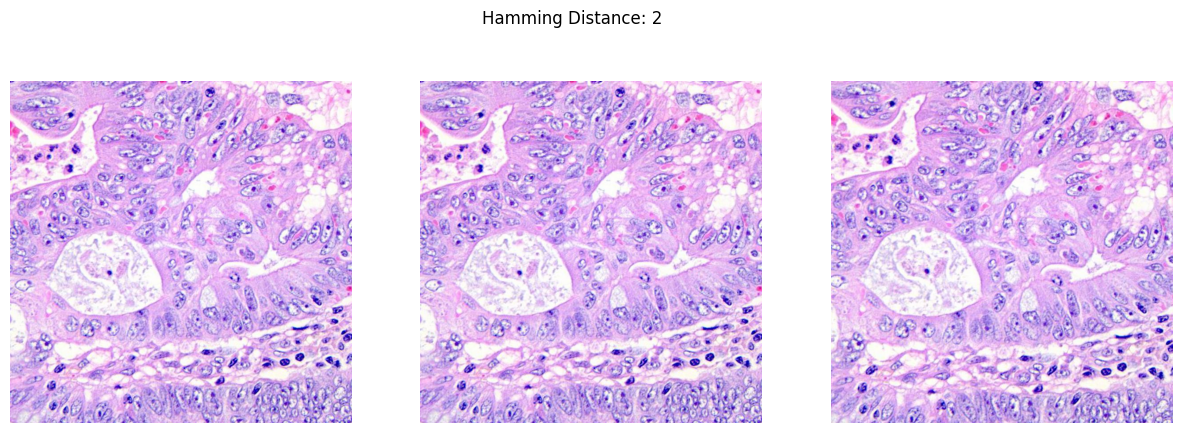

In [ ]:
!pip install imagehash Pillow tqdm

import imagehash
from PIL import Image
from tqdm import tqdm



# Compute Image Hashes

# Initialize an empty dictionary to store hashes
hashes = {}

# Iterate over all images and compute hashes
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # Open the image file
        image = Image.open(row['filename'])
        # Compute the perceptual hash
        image_hash = imagehash.phash(image)
        # Store the hash as a string
        hashes[row['filename']] = str(image_hash)
    except Exception as e:
        # Handle images that can't be opened
        hashes[row['filename']] = None

# Add the hashes to the DataFrame
df['image_hash'] = df['filename'].map(hashes)


# Identify Duplicates

# Find Exact Duplicates

# Count the number of occurrences of each hash
hash_counts = df['image_hash'].value_counts()

# Identify hashes that occur more than once
duplicate_hashes = hash_counts[hash_counts > 1].index

# Filter the DataFrame to show only duplicate images
duplicates_df = df[df['image_hash'].isin(duplicate_hashes)].copy()

print(f"Number of duplicate images found: {len(duplicates_df)}")
print("List of duplicate images:")
print(duplicates_df[['filename', 'label', 'image_hash']].head())



# Find Near-Duplicates

from itertools import combinations
from collections import defaultdict

# Create a mapping from image hashes to filenames
hash_to_filenames = defaultdict(list)
for idx, row in df.iterrows():
    hash_to_filenames[row['image_hash']].append(row['filename'])

# Convert hash strings to integers for computation
hash_to_int = {h: int(h, 16) for h in hash_to_filenames if h is not None}

# Set a Hamming distance threshold
threshold = 5  # Adjust this value based on desired sensitivity

# Find near-duplicates
near_duplicates = []

# Generate combinations of hashes
hash_list = list(hash_to_int.keys())
for i in tqdm(range(len(hash_list))):
    hash1 = hash_to_int[hash_list[i]]
    filenames1 = hash_to_filenames[hash_list[i]]
    for j in range(i + 1, len(hash_list)):
        hash2 = hash_to_int[hash_list[j]]
        filenames2 = hash_to_filenames[hash_list[j]]
        # Compute Hamming distance
        hamming_dist = bin(hash1 ^ hash2).count('1')
        if hamming_dist <= threshold:
            near_duplicates.append({
                'hash1': hash_list[i],
                'hash2': hash_list[j],
                'filenames1': filenames1,
                'filenames2': filenames2,
                'hamming_distance': hamming_dist
            })

print(f"Number of near-duplicate pairs found: {len(near_duplicates)}")



# Analyze Results

# View Exact Duplicates

# Group duplicates by image_hash
duplicate_groups = duplicates_df.groupby('image_hash')

# Display duplicates
for image_hash, group in duplicate_groups:
    print(f"\nDuplicate group with hash {image_hash}:")
    display(group[['filename', 'label']])


# View Near-Duplicates

# Display near-duplicate pairs
for nd in near_duplicates[:5]:  # Show first 5 for brevity
    print(f"\nHamming Distance: {nd['hamming_distance']}")
    print("Images in group 1:")
    for fname in nd['filenames1']:
        print(f" - {fname}")
    print("Images in group 2:")
    for fname in nd['filenames2']:
        print(f" - {fname}")



# Visualization
import matplotlib.pyplot as plt

def display_images(image_paths, title):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    fig.suptitle(title)
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Display images for the first near-duplicate pair
if near_duplicates:
    nd = near_duplicates[0]
    display_images(nd['filenames1'] + nd['filenames2'], f"Hamming Distance: {nd['hamming_distance']}")

Checking for Patches (I believe I did this before do the previous check for "Filename Number Correlations". Based on the results of that, patches might not be a thing, but I'm not 100% sure.

In [ ]:
import re

def extract_number(filename):
    # Extract the number from the filename
    match = re.search(r'(\d+)\.jpeg$', filename)
    return int(match.group(1)) if match else None

def check_sequential_patches(df, window=10):
    sequences = []
    for label in df['label'].unique():
        label_files = df[df['label'] == label]['filename']
        numbers = sorted([extract_number(f) for f in label_files])

        # Look for close sequential numbers
        for i in range(len(numbers)-1):
            if numbers[i+1] - numbers[i] <= window:
                sequences.append((label, numbers[i], numbers[i+1]))

    return sequences

# Check for nearby sequence numbers within each set
print("Checking for potentially related patches...")
print("\nIn Training set:")
train_sequences = check_sequential_patches(train_df)
print(f"Found {len(train_sequences)} potentially related pairs")
if train_sequences:
    print("First few examples:", train_sequences[:5])

# Check for nearby sequence numbers across sets
def check_cross_set_similarity(df1, df2, window=10):
    df1_numbers = [(extract_number(f), l) for f, l in zip(df1['filename'], df1['label'])]
    df2_numbers = [(extract_number(f), l) for f, l in zip(df2['filename'], df2['label'])]

    close_pairs = []
    for num1, label1 in df1_numbers:
        for num2, label2 in df2_numbers:
            if label1 == label2 and abs(num1 - num2) <= window:
                close_pairs.append((label1, num1, num2))

    return close_pairs

print("\nChecking for potentially related patches across sets...")
train_test_similar = check_cross_set_similarity(train_df, test_df)
print(f"Found {len(train_test_similar)} potentially related pairs between train and test")
if train_test_similar:
    print("First few examples:", train_test_similar[:5])

Checking for potentially related patches...

In Training set:
Found 14 potentially related pairs
First few examples: [('colon_n', 2585, 2593), ('colon_n', 3360, 3370), ('colon_n', 3633, 3639), ('colon_n', 3673, 3677), ('colon_aca', 1330, 1339)]

Checking for potentially related patches across sets...
Found 712 potentially related pairs between train and test
First few examples: [('colon_n', 555, 561), ('colon_n', 555, 552), ('colon_n', 555, 554), ('colon_n', 555, 557), ('colon_n', 555, 548)]


The 712 potentially related pairs between train and test may be the source of data leakage through related patches from the same whole slide images (WSIs) being split across training and test sets.

To fix this, I'm trying to implement a more robust train/test split that keeps all patches from the same WSI together



In [23]:
def get_patch_group(filename):
    # Group patches by hundreds to keep related patches together
    number = extract_number(filename)
    return number // 100

def strategic_split(df, test_size=0.2, val_size=0.2):
    # Get unique patch groups
    df['patch_group'] = df['filename'].apply(get_patch_group)
    unique_groups = df['patch_group'].unique()

    # Split at the group level
    test_groups = set(np.random.choice(
        unique_groups,
        size=int(len(unique_groups) * test_size),
        replace=False
    ))

    remaining_groups = set(unique_groups) - test_groups
    val_groups = set(np.random.choice(
        list(remaining_groups),
        size=int(len(unique_groups) * val_size),
        replace=False
    ))
    train_groups = remaining_groups - val_groups

    # Split the dataframe
    train_df = df[df['patch_group'].isin(train_groups)]
    val_df = df[df['patch_group'].isin(val_groups)]
    test_df = df[df['patch_group'].isin(test_groups)]

    return train_df, val_df, test_df